# Learning PyTorch: Defining new autograd functions

Source: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-defining-new-autograd-functions


Under the hood, each primitive autograd operator is really two functions that operate on Tensors. The `forward` function computes output Tensors from input Tensors. The `backward` function receives the gradient of the output Tensors with respect to some scalar value, and computes the gradient of the input Tensors with respect to that same scalar value.

If `x` is a Tensor that has `x.requires_grad=True` then `x.grad` is another Tensor holding the gradient of `x` with respect to some scalar value.

In PyTorch we can easily define our own autograd operator by defining a subclass of `torch.autograd.Function` and implementing the `forward` and `backward` functions. We can then use our new autograd operator by constructing an instance and calling it like a function, passing Tensors containing input data.

In this example we define our model as  instead of , where 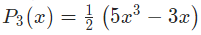 is the Legendre polynomial of degree three.

We write our own custom autograd function for computing forward and backward of , and use it to implement our model.

In [1]:
import torch
import math

class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing torch.autograd.Function 
    and implementing the forward and backward passes which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In forward pass we receive a Tensor containing input and return a Tensor containing output. 
        ctx is a context object that can be used to stash information for backward computation. 
        You can cache arbitrary objects for use in the backward pass using the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In backward pass we receive a Tensor containing gradient of the loss with respect to the output, 
        and we need to compute the gradient of the loss with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)

In [2]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

In [3]:
# Create Tensors to hold input and outputs.
# By default, 'requires_grad=False', which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

In [4]:
# Create random Tensors for weights. 
# For this example, we need 4 weights: y = a + b * P3(c + d * x), 
# these weights need to be initialized not too far from the correct result to ensure convergence.
# Setting 'requires_grad=True' indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.

a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

In [5]:
learning_rate = 5e-6

for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = LegendrePolynomial3.apply

    # Forward pass: compute predicted y using operations; 
    # we compute P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item()) # loss.item() gets the scalar value held in the loss.

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

99 209.95834350585938
199 144.66018676757812
299 100.70249938964844
399 71.03519439697266
499 50.97850799560547
599 37.403133392333984
699 28.206867218017578
799 21.97318458557129
899 17.7457275390625
999 14.877889633178711
1099 12.93176555633545
1199 11.610918998718262
1299 10.71425724029541
1399 10.10548210144043
1499 9.692106246948242
1599 9.411375045776367
1699 9.220745086669922
1799 9.091285705566406
1899 9.003360748291016
1999 8.943639755249023
Result: y = -5.394172664097141e-09 + -2.208526849746704 * P3(1.367587154632588e-09 + 0.2554861009120941 x)
